In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import numpy as np
import random
import pandas as pd

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
from google.colab import drive

drive.mount('/content/drive')

# 재현 가능성을 위한 시드 고정
RANDOM_SEED = 18
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Dataloader 시드 고정 (아직 사용 x)
generator = torch.Generator()
generator.manual_seed(RANDOM_SEED)

def worker_init_fn(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


# 데이터 경로 설정
train_csv_path = "/content/drive/MyDrive/Samsung_AI_challenge/Data/train.csv"
test_csv_path = "/content/drive/MyDrive/Samsung_AI_challenge/Data/test.csv"
submission_csv_path = '/content/drive/MyDrive/Samsung_AI_challenge/Data/sample_submission.csv'

# 기타 경로 설정 : 저장되는 데이터 이름 등 (model, method 에 맞게 설정)


Mounted at /content/drive


In [2]:
# 훈련 데이터를 훈련 + 검증 데이터로 나누고 train_dataset, val_dataset 을 반환하는 함수
from sklearn.preprocessing import MinMaxScaler

def split_dataloader(train_csv_path, val_ratio=0.2, random_state=RANDOM_SEED):
    train_data = pd.read_csv(train_csv_path)

    X = torch.tensor(train_data.iloc[:,1:-1].values, dtype=torch.float32)
    y = torch.tensor(train_data.iloc[:,-1].values, dtype = torch.float32).view(-1,1)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_ratio, random_state=random_state)

    scaler = MinMaxScaler()  # Min-Max Scaler를 사용
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    return train_dataset, val_dataset

train_dataset, val_dataset = split_dataloader(train_csv_path)

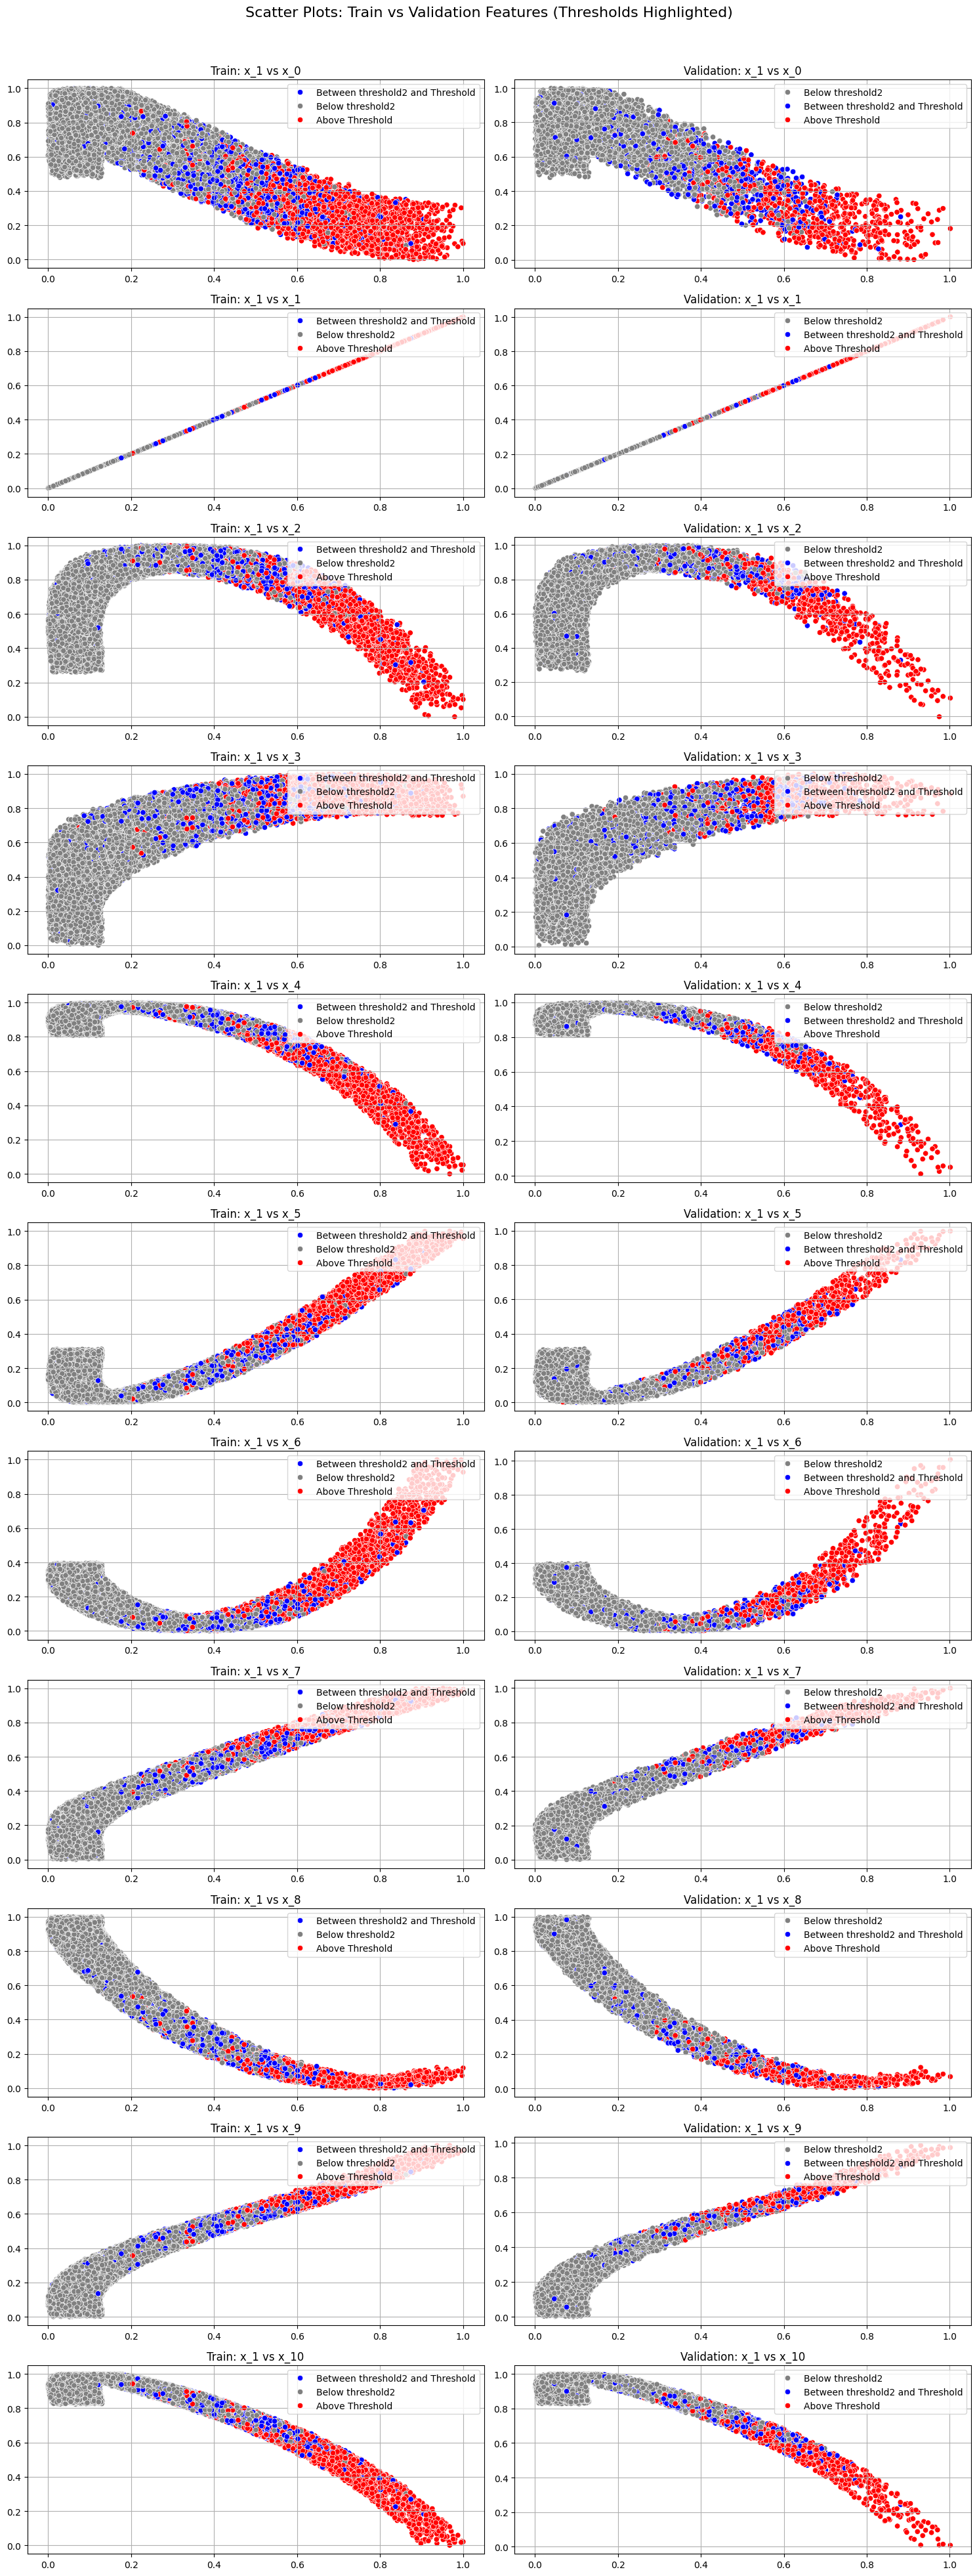

In [3]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# train_dataset과 val_dataset에서 y 값 추출
y_train = train_dataset.tensors[1].numpy().ravel()
y_val = val_dataset.tensors[1].numpy().ravel()

# y 값에 따라 색상 라벨 설정 함수
threshold = np.quantile(y_train, 0.9)
threshold2 = np.quantile(y_train, 0.80)

def color_label(y):
    if y >= threshold:
        return 'Above Threshold'
    elif threshold2 <= y < threshold:
        return 'Between threshold2 and Threshold'
    else:
        return 'Below threshold2'

# 각 데이터셋에 대해 색상 라벨 적용
train_color_labels = np.array([color_label(y) for y in y_train])
val_color_labels = np.array([color_label(y) for y in y_val])

# 피처 리스트 설정 (x_0 ~ x_10)
feature_columns = [f'x_{i}' for i in range(11)]

# 서브플롯 생성 (11행 2열로 설정, 총 11개의 피처 비교)
fig, axes = plt.subplots(11, 2, figsize=(15, 40))
fig.suptitle('Scatter Plots: Train vs Validation Features (Thresholds Highlighted)', fontsize=16)

for i, feature in enumerate(feature_columns):
    i
    row = i

    # Train 데이터셋 산점도 (왼쪽)
    sns.scatterplot(x=train_dataset.tensors[0][:, 1].numpy(), y=train_dataset.tensors[0][:, i].numpy(),
                    hue=train_color_labels, ax=axes[row, 0],
                    palette={'Above Threshold': 'red', 'Between threshold2 and Threshold': 'blue', 'Below threshold2': 'gray'})
    axes[row, 0].set_title(f'Train: x_1 vs {feature}')
    axes[row, 0].grid(True)
    axes[row, 0].legend(loc='upper right')

    # Validation 데이터셋 산점도 (오른쪽)
    sns.scatterplot(x=val_dataset.tensors[0][:, 1].numpy(), y=val_dataset.tensors[0][:, i].numpy(),
                    hue=val_color_labels, ax=axes[row, 1],
                    palette={'Above Threshold': 'red', 'Between threshold2 and Threshold': 'blue', 'Below threshold2': 'gray'})
    axes[row, 1].set_title(f'Validation: x_1 vs {feature}')
    axes[row, 1].grid(True)
    axes[row, 1].legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.97])  # suptitle과 겹치지 않도록 조정
plt.show()

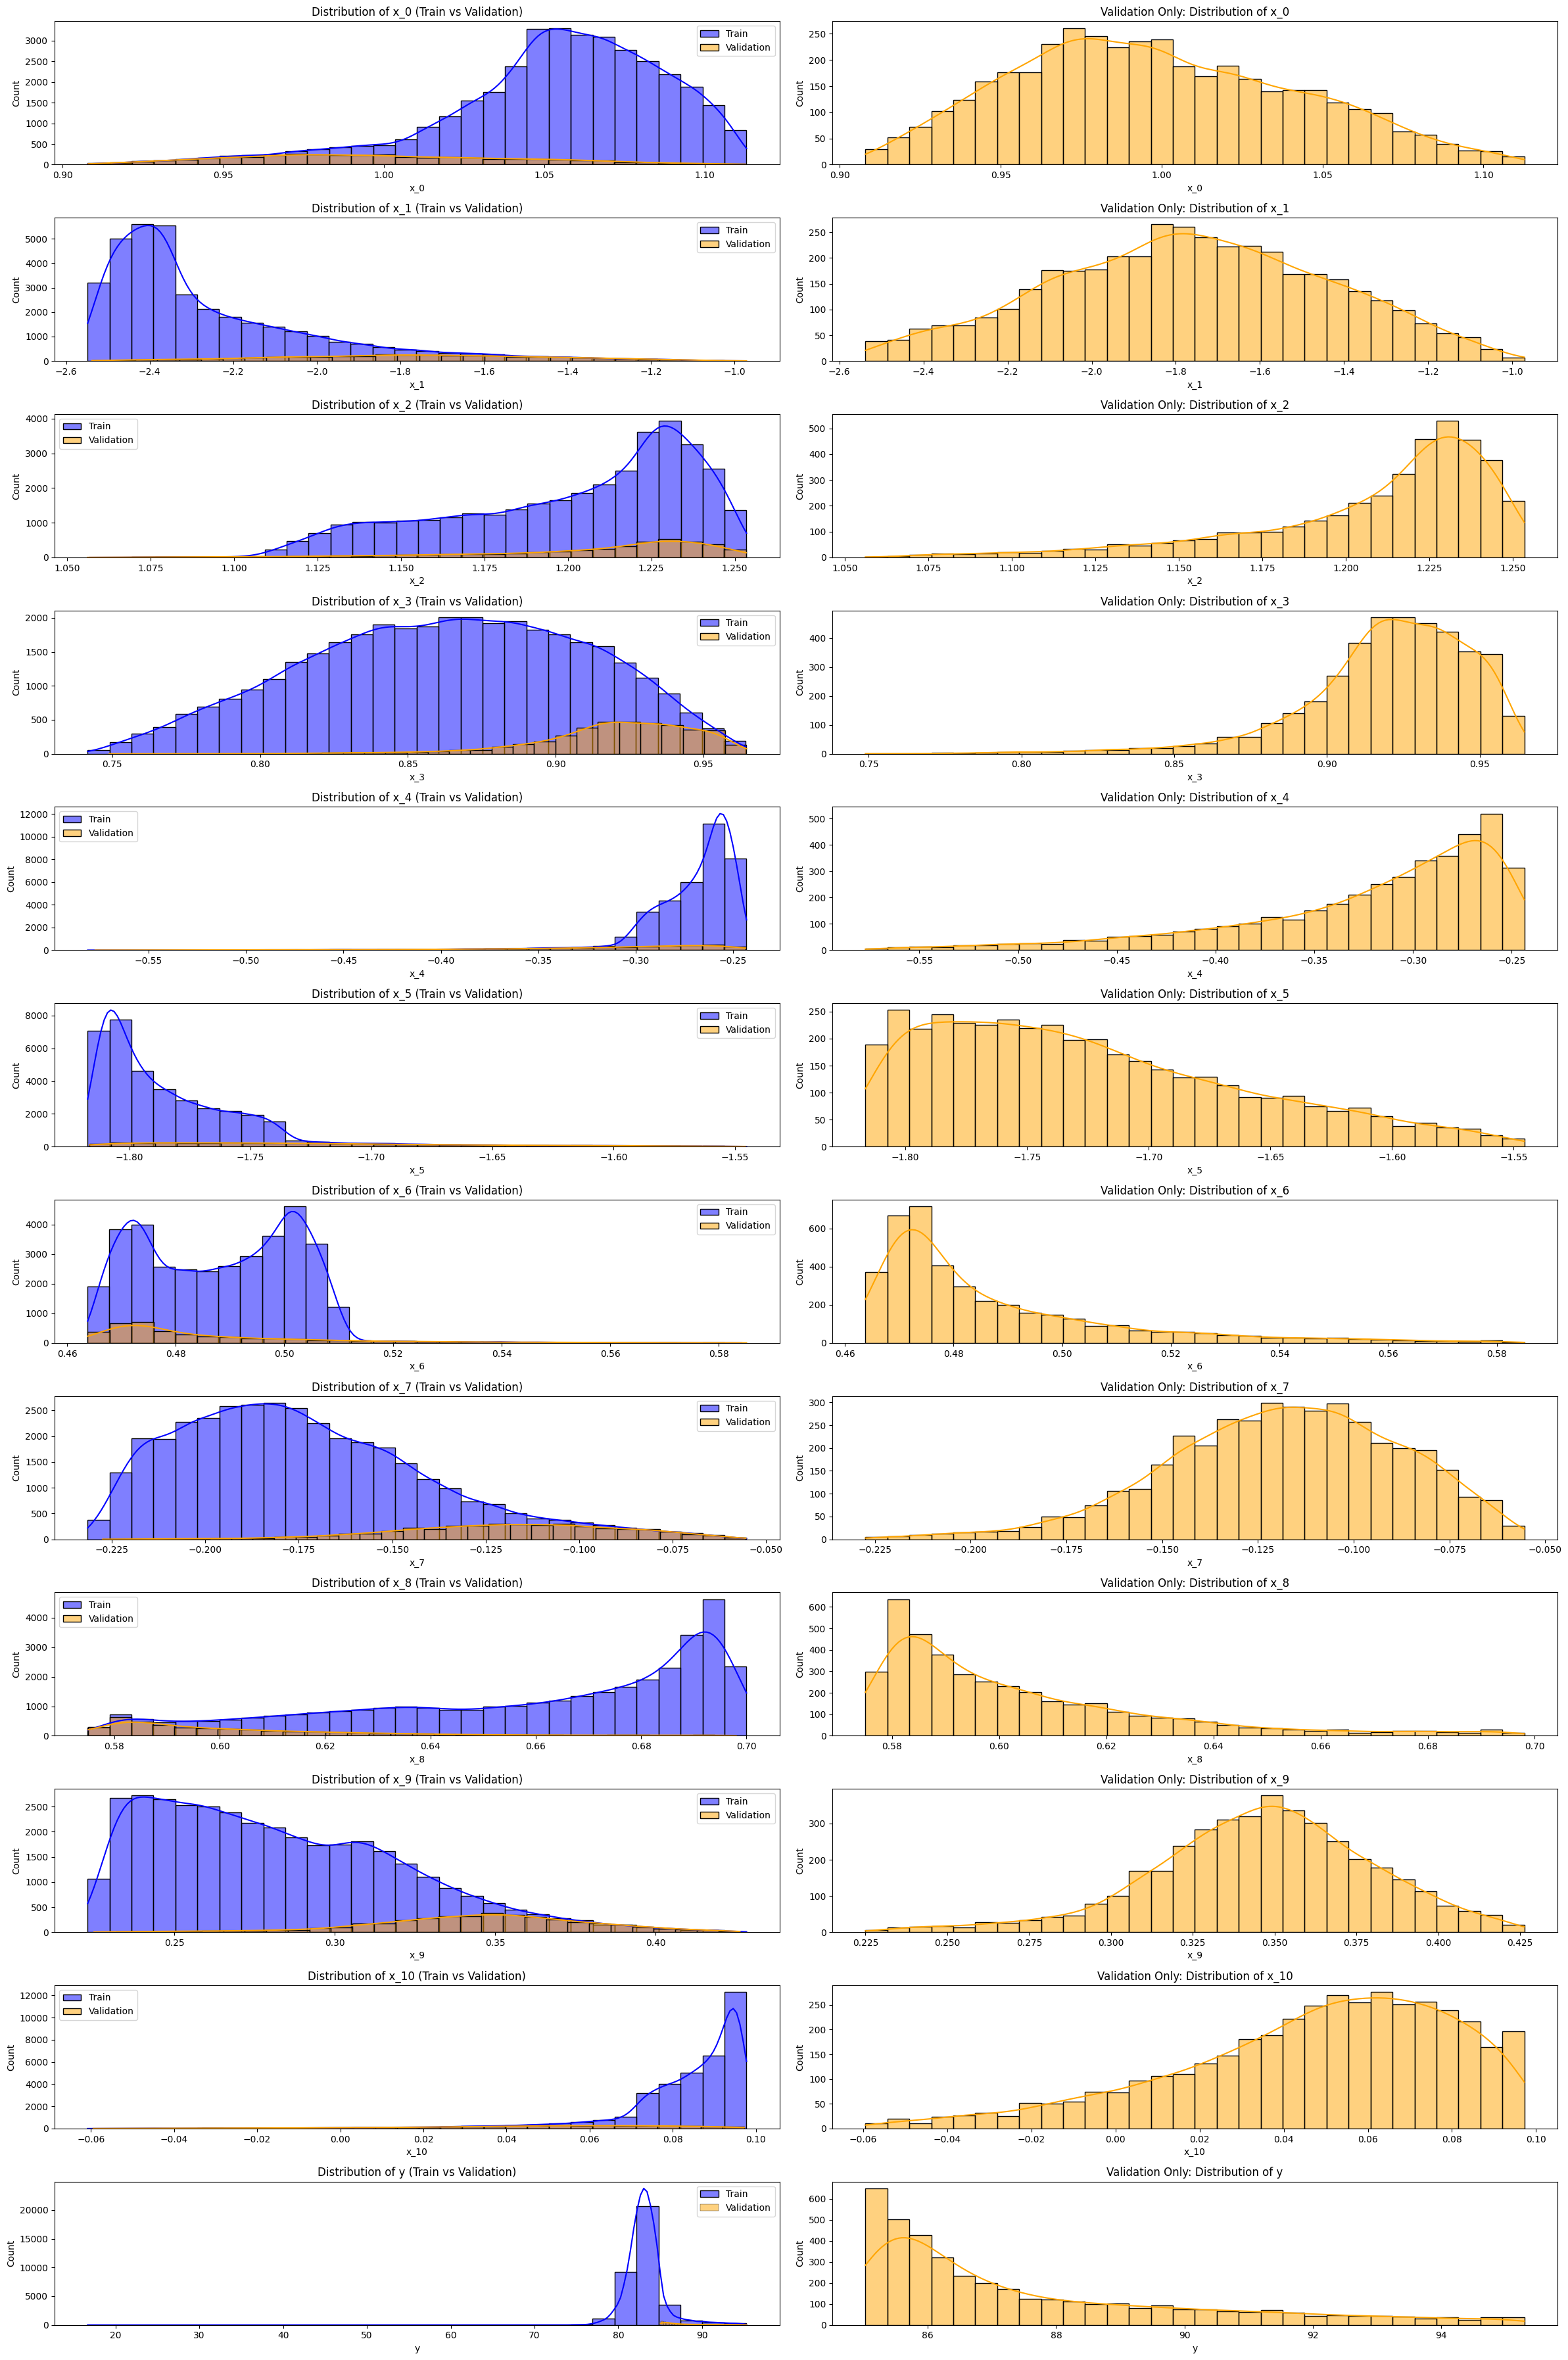

In [ ]:
# import pandas as pd
# import torch
# from sklearn.model_selection import train_test_split
# from torch.utils.data import TensorDataset
# import matplotlib.pyplot as plt
# import seaborn as sns

# def split_dataloader_with_top_data(train_csv_path, val_ratio=0.2, top_data_ratio=0.5, random_state=42):
#     # 데이터 로드
#     train_data = pd.read_csv(train_csv_path)

#     X = torch.tensor(train_data.iloc[:, 1:-1].values, dtype=torch.float32)
#     y = torch.tensor(train_data.iloc[:, -1].values, dtype=torch.float32).view(-1, 1)

#     # y의 상위 20%에 해당하는 임계값 계산
#     threshold = torch.quantile(y, 0.80)

#     # 상위 20% 데이터를 검증 데이터셋으로 부분적으로 분리
#     top_data_indices = (y >= threshold).squeeze()
#     bottom_data_indices = ~top_data_indices

#     X_top, y_top = X[top_data_indices], y[top_data_indices]
#     X_bottom, y_bottom = X[bottom_data_indices], y[bottom_data_indices]

#     # 상위 20% 데이터를 훈련과 검증 데이터로 나누기
#     X_top_train, X_top_val, y_top_train, y_top_val = train_test_split(
#         X_top, y_top, test_size=top_data_ratio, random_state=random_state)

#     # 하위 80% 데이터를 훈련 데이터로 사용
#     X_train = torch.cat((X_bottom, X_top_train), dim=0)
#     y_train = torch.cat((y_bottom, y_top_train), dim=0)

#     # 상위 10% 데이터의 일부를 검증 데이터로 사용
#     X_val = X_top_val
#     y_val = y_top_val

#     # TensorDataset 생성
#     train_dataset = TensorDataset(X_train, y_train)
#     val_dataset = TensorDataset(X_val, y_val)

#     return train_dataset, val_dataset

# # 데이터셋 분할 실행
# train_dataset, val_dataset = split_dataloader_with_top_data(train_csv_path)

# # X_train과 X_val 데이터에서 각 피처의 분포 시각화 (12행 2열 서브플롯)
# plt.figure(figsize=(24, 36))
# feature_columns = [f'x_{i}' for i in range(11)]

# for i, feature in enumerate(feature_columns):
#     # 왼쪽: 훈련 데이터와 검증 데이터의 겹친 분포
#     plt.subplot(12, 2, 2 * i + 1)
#     sns.histplot(train_dataset.tensors[0][:, i].numpy(), kde=True, bins=30, color='blue', label='Train', alpha=0.5)
#     sns.histplot(val_dataset.tensors[0][:, i].numpy(), kde=True, bins=30, color='orange', label='Validation', alpha=0.5)
#     plt.title(f'Distribution of {feature} (Train vs Validation)')
#     plt.xlabel(feature)
#     plt.ylabel('Count')
#     plt.legend()

#     # 오른쪽: 검증 데이터의 분포만 시각화
#     plt.subplot(12, 2, 2 * i + 2)
#     sns.histplot(val_dataset.tensors[0][:, i].numpy(), kde=True, bins=30, color='orange')
#     plt.title(f'Validation Only: Distribution of {feature}')
#     plt.xlabel(feature)
#     plt.ylabel('Count')

# # 마지막 서브플롯에 y 값의 분포 추가
# plt.subplot(12, 2, 23)
# sns.histplot(train_dataset.tensors[1].numpy().ravel(), kde=True, bins=30, color='blue', label='Train', alpha=0.5)
# sns.histplot(val_dataset.tensors[1].numpy().ravel(), kde=True, bins=30, color='orange', label='Validation', alpha=0.5)
# plt.title('Distribution of y (Train vs Validation)')
# plt.xlabel('y')
# plt.ylabel('Count')
# plt.legend()

# plt.subplot(12, 2, 24)
# sns.histplot(val_dataset.tensors[1].numpy().ravel(), kde=True, bins=30, color='orange')
# plt.title('Validation Only: Distribution of y')
# plt.xlabel('y')
# plt.ylabel('Count')

# plt.tight_layout()
# plt.show()

In [ ]:
print(len(train_dataset))
print(len(val_dataset))

32094
8024


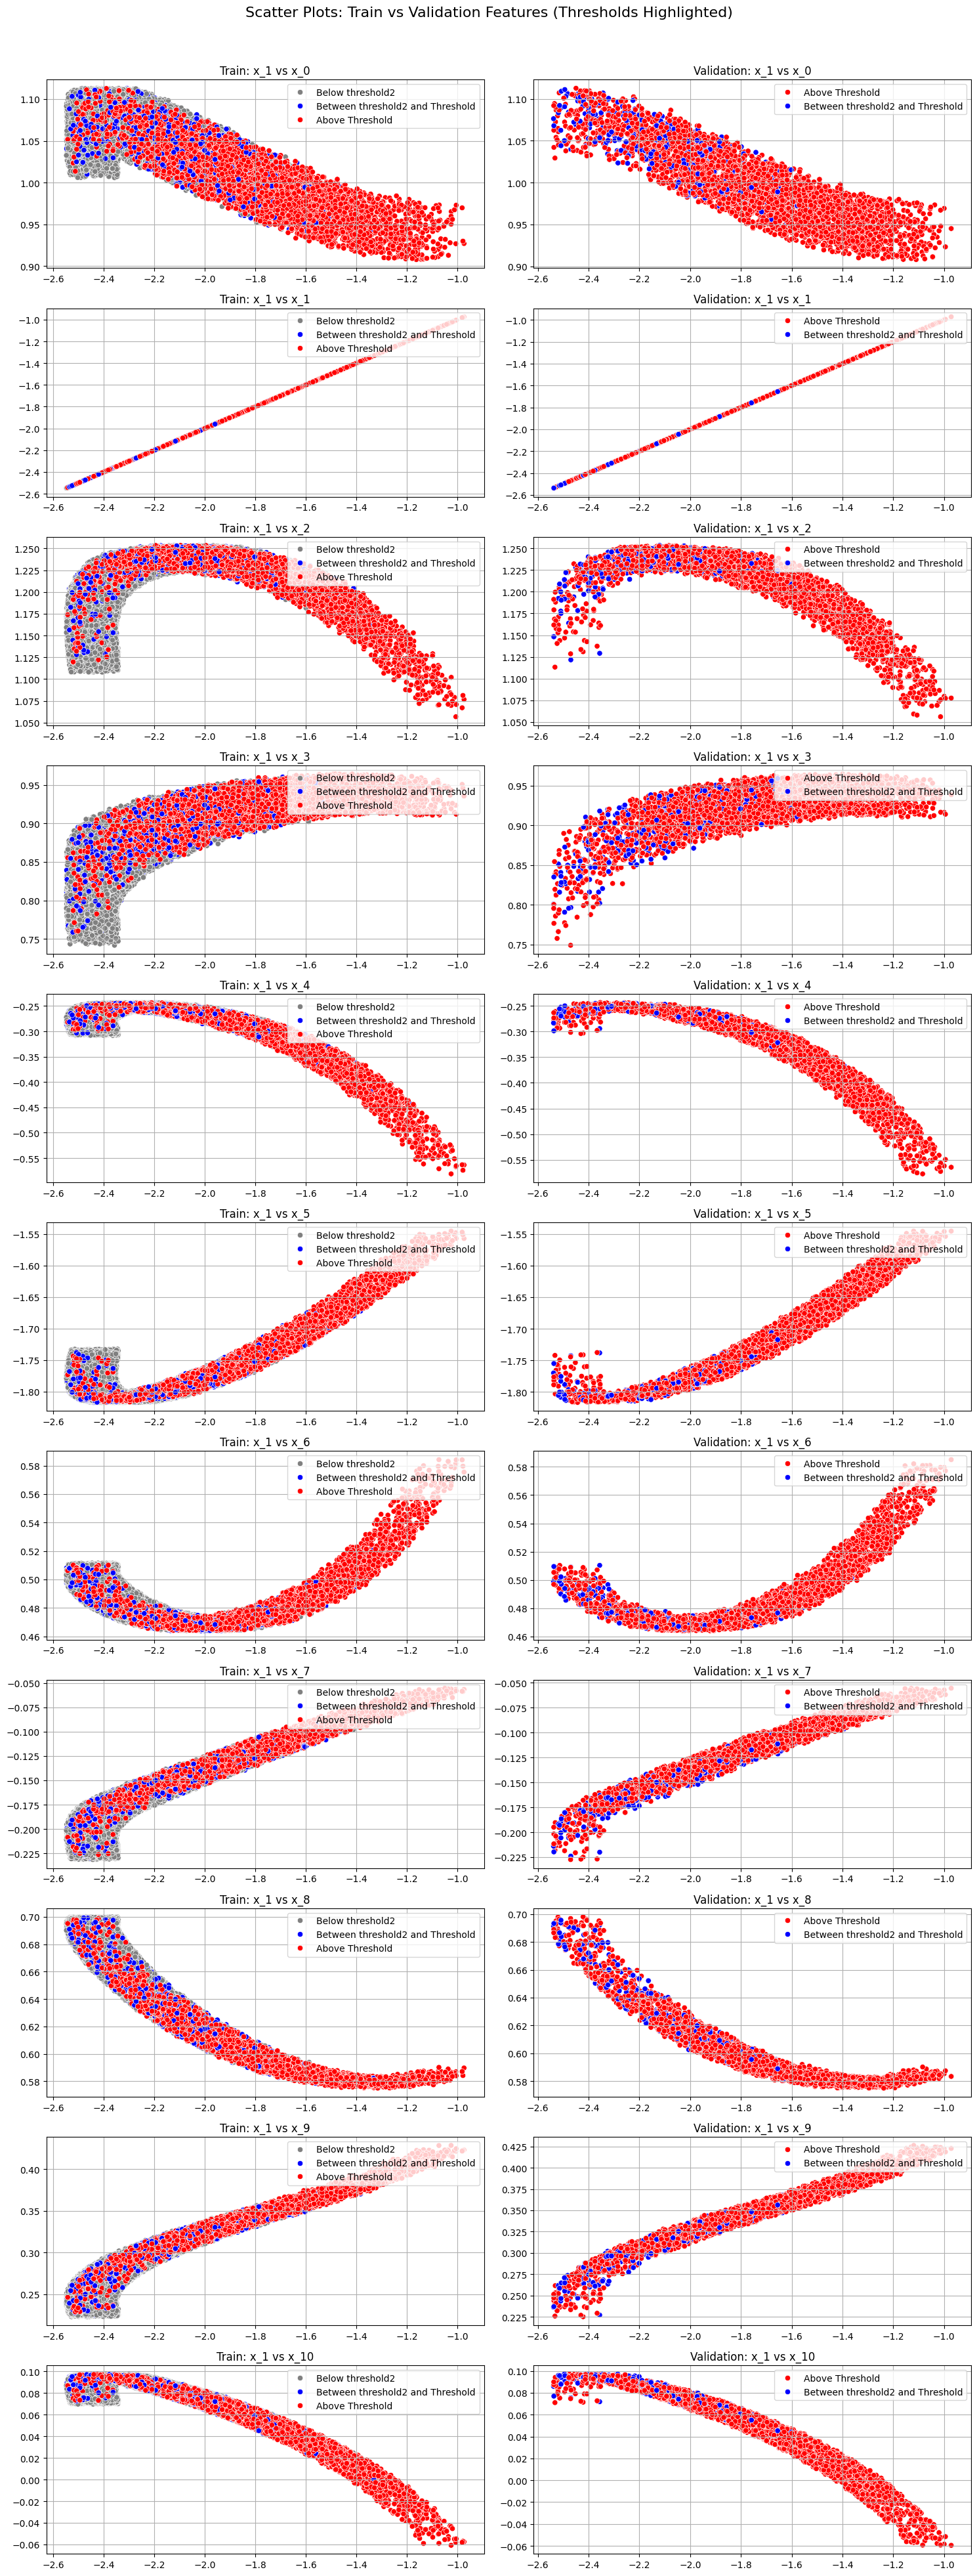

In [ ]:
# import pandas as pd
# import torch
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # train_dataset과 val_dataset에서 y 값 추출
# y_train = train_dataset.tensors[1].numpy().ravel()
# y_val = val_dataset.tensors[1].numpy().ravel()

# # y 값에 따라 색상 라벨 설정 함수
# threshold = np.quantile(y_train, 0.9)
# threshold2 = np.quantile(y_train, 0.80)

# def color_label(y):
#     if y >= threshold:
#         return 'Above Threshold'
#     elif threshold2 <= y < threshold:
#         return 'Between threshold2 and Threshold'
#     else:
#         return 'Below threshold2'

# # 각 데이터셋에 대해 색상 라벨 적용
# train_color_labels = np.array([color_label(y) for y in y_train])
# val_color_labels = np.array([color_label(y) for y in y_val])

# # 피처 리스트 설정 (x_0 ~ x_10)
# feature_columns = [f'x_{i}' for i in range(11)]

# # 서브플롯 생성 (11행 2열로 설정, 총 11개의 피처 비교)
# fig, axes = plt.subplots(11, 2, figsize=(15, 40))
# fig.suptitle('Scatter Plots: Train vs Validation Features (Thresholds Highlighted)', fontsize=16)

# for i, feature in enumerate(feature_columns):
#     i
#     row = i

#     # Train 데이터셋 산점도 (왼쪽)
#     sns.scatterplot(x=train_dataset.tensors[0][:, 1].numpy(), y=train_dataset.tensors[0][:, i].numpy(),
#                     hue=train_color_labels, ax=axes[row, 0],
#                     palette={'Above Threshold': 'red', 'Between threshold2 and Threshold': 'blue', 'Below threshold2': 'gray'})
#     axes[row, 0].set_title(f'Train: x_1 vs {feature}')
#     axes[row, 0].grid(True)
#     axes[row, 0].legend(loc='upper right')

#     # Validation 데이터셋 산점도 (오른쪽)
#     sns.scatterplot(x=val_dataset.tensors[0][:, 1].numpy(), y=val_dataset.tensors[0][:, i].numpy(),
#                     hue=val_color_labels, ax=axes[row, 1],
#                     palette={'Above Threshold': 'red', 'Between threshold2 and Threshold': 'blue', 'Below threshold2': 'gray'})
#     axes[row, 1].set_title(f'Validation: x_1 vs {feature}')
#     axes[row, 1].grid(True)
#     axes[row, 1].legend(loc='upper right')

# plt.tight_layout(rect=[0, 0, 1, 0.97])  # suptitle과 겹치지 않도록 조정
# plt.show()

In [ ]:
# print(threshold)
# print(threshold2)

85.21152114868164
84.39293670654297


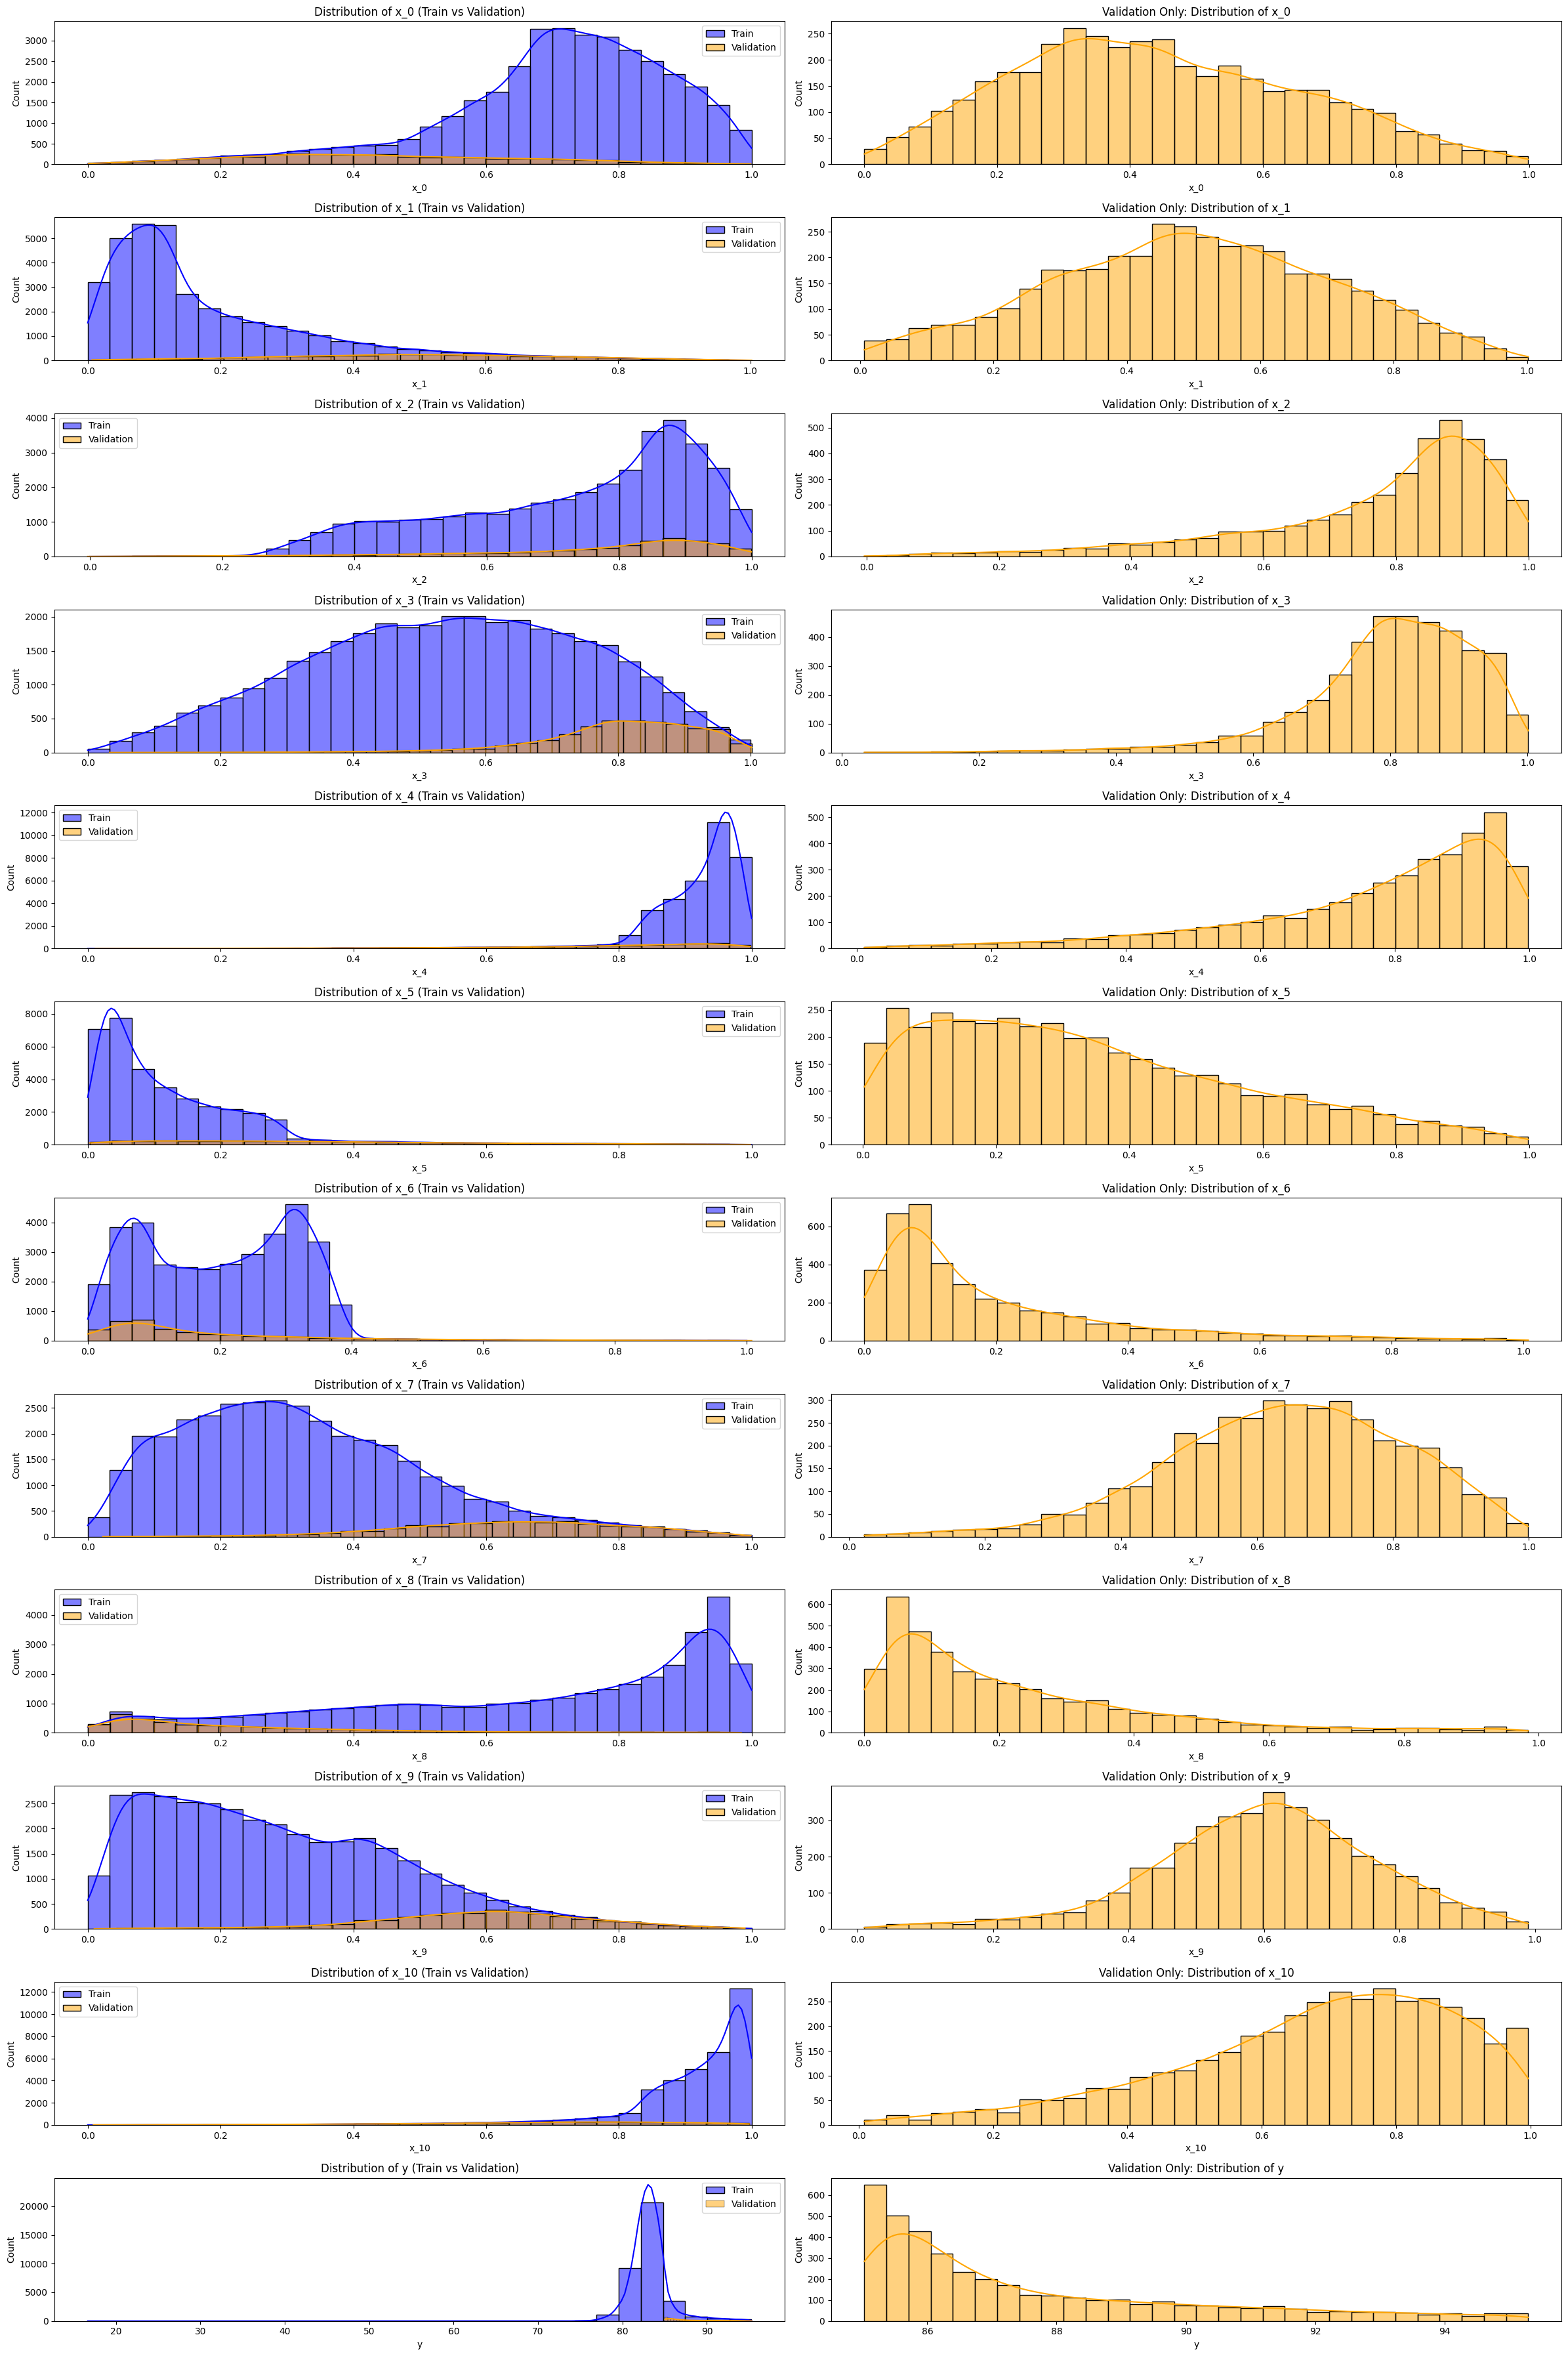

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# def split_dataloader_with_minmax_normalization(train_csv_path, val_ratio=0.2, top_data_ratio=0.5, random_state=42):
#     # 데이터 로드
#     train_data = pd.read_csv(train_csv_path)

#     X = train_data.iloc[:, 1:-1].values
#     y = train_data.iloc[:, -1].values

#     # y의 상위 20%에 해당하는 임계값 계산
#     threshold = torch.quantile(torch.tensor(y), 0.80)

#     # 상위 20% 데이터를 검증 데이터셋으로 부분적으로 분리
#     top_data_indices = y >= threshold.numpy()
#     bottom_data_indices = ~top_data_indices

#     X_top, y_top = X[top_data_indices], y[top_data_indices]
#     X_bottom, y_bottom = X[bottom_data_indices], y[bottom_data_indices]

#     # 상위 20% 데이터를 훈련과 검증 데이터로 나누기
#     X_top_train, X_top_val, y_top_train, y_top_val = train_test_split(
#         X_top, y_top, test_size=top_data_ratio, random_state=random_state)

#     # 하위 90% 데이터를 훈련 데이터로 사용
#     X_train = np.vstack((X_bottom, X_top_train))
#     y_train = np.hstack((y_bottom, y_top_train))

#     # 상위 10% 데이터의 일부를 검증 데이터로 사용
#     X_val = X_top_val
#     y_val = y_top_val

#     # Min-Max 정규화 적용
#     scaler = MinMaxScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_val = scaler.transform(X_val)

#     # TensorDataset 생성
#     X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
#     y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
#     X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
#     y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

#     train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#     val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

#     return train_dataset, val_dataset

# # 데이터셋 분할 실행
# train_dataset, val_dataset = split_dataloader_with_minmax_normalization(train_csv_path)

# # 나머지 시각화 코드는 동일하게 유지됩니다.
# # X_train과 X_val 데이터에서 각 피처의 분포 시각화 (12행 2열 서브플롯)
# plt.figure(figsize=(24, 36))
# feature_columns = [f'x_{i}' for i in range(11)]

# for i, feature in enumerate(feature_columns):
#     # 왼쪽: 훈련 데이터와 검증 데이터의 겹친 분포
#     plt.subplot(12, 2, 2 * i + 1)
#     sns.histplot(train_dataset.tensors[0][:, i].numpy(), kde=True, bins=30, color='blue', label='Train', alpha=0.5)
#     sns.histplot(val_dataset.tensors[0][:, i].numpy(), kde=True, bins=30, color='orange', label='Validation', alpha=0.5)
#     plt.title(f'Distribution of {feature} (Train vs Validation)')
#     plt.xlabel(feature)
#     plt.ylabel('Count')
#     plt.legend()

#     # 오른쪽: 검증 데이터의 분포만 시각화
#     plt.subplot(12, 2, 2 * i + 2)
#     sns.histplot(val_dataset.tensors[0][:, i].numpy(), kde=True, bins=30, color='orange')
#     plt.title(f'Validation Only: Distribution of {feature}')
#     plt.xlabel(feature)
#     plt.ylabel('Count')

# # 마지막 서브플롯에 y 값의 분포 추가
# plt.subplot(12, 2, 23)
# sns.histplot(train_dataset.tensors[1].numpy().ravel(), kde=True, bins=30, color='blue', label='Train', alpha=0.5)
# sns.histplot(val_dataset.tensors[1].numpy().ravel(), kde=True, bins=30, color='orange', label='Validation', alpha=0.5)
# plt.title('Distribution of y (Train vs Validation)')
# plt.xlabel('y')
# plt.ylabel('Count')
# plt.legend()

# plt.subplot(12, 2, 24)
# sns.histplot(val_dataset.tensors[1].numpy().ravel(), kde=True, bins=30, color='orange')
# plt.title('Validation Only: Distribution of y')
# plt.xlabel('y')
# plt.ylabel('Count')

# plt.tight_layout()
# plt.show()

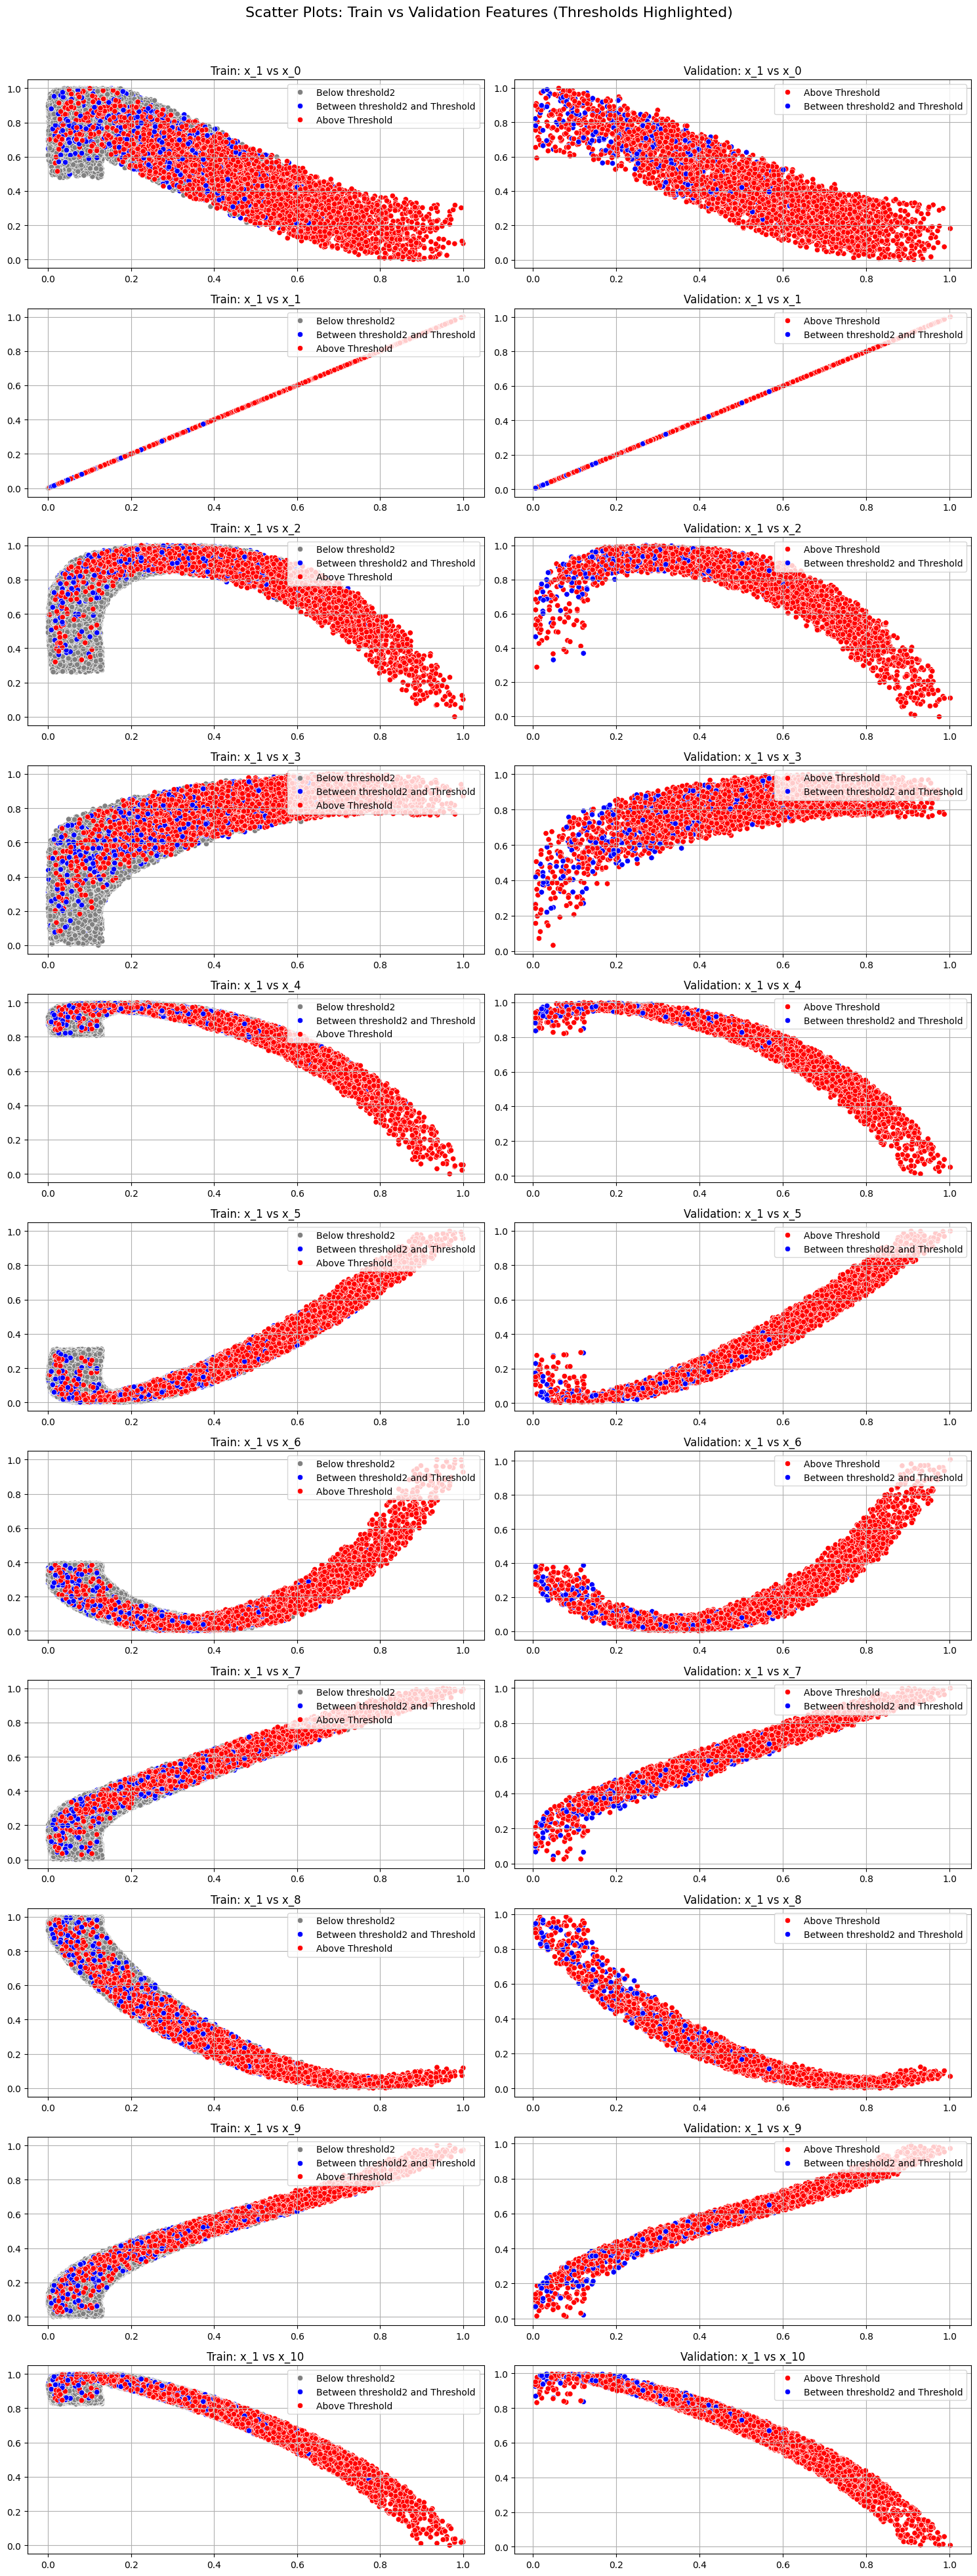

In [ ]:
# import pandas as pd
# import torch
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # train_dataset과 val_dataset에서 y 값 추출
# y_train = train_dataset.tensors[1].numpy().ravel()
# y_val = val_dataset.tensors[1].numpy().ravel()

# # y 값에 따라 색상 라벨 설정 함수
# threshold = np.quantile(y_train, 0.9)
# threshold2 = np.quantile(y_train, 0.80)

# def color_label(y):
#     if y >= threshold:
#         return 'Above Threshold'
#     elif threshold2 <= y < threshold:
#         return 'Between threshold2 and Threshold'
#     else:
#         return 'Below threshold2'

# # 각 데이터셋에 대해 색상 라벨 적용
# train_color_labels = np.array([color_label(y) for y in y_train])
# val_color_labels = np.array([color_label(y) for y in y_val])

# # 피처 리스트 설정 (x_0 ~ x_10)
# feature_columns = [f'x_{i}' for i in range(11)]

# # 서브플롯 생성 (11행 2열로 설정, 총 11개의 피처 비교)
# fig, axes = plt.subplots(11, 2, figsize=(15, 40))
# fig.suptitle('Scatter Plots: Train vs Validation Features (Thresholds Highlighted)', fontsize=16)

# for i, feature in enumerate(feature_columns):
#     i
#     row = i

#     # Train 데이터셋 산점도 (왼쪽)
#     sns.scatterplot(x=train_dataset.tensors[0][:, 1].numpy(), y=train_dataset.tensors[0][:, i].numpy(),
#                     hue=train_color_labels, ax=axes[row, 0],
#                     palette={'Above Threshold': 'red', 'Between threshold2 and Threshold': 'blue', 'Below threshold2': 'gray'})
#     axes[row, 0].set_title(f'Train: x_1 vs {feature}')
#     axes[row, 0].grid(True)
#     axes[row, 0].legend(loc='upper right')

#     # Validation 데이터셋 산점도 (오른쪽)
#     sns.scatterplot(x=val_dataset.tensors[0][:, 1].numpy(), y=val_dataset.tensors[0][:, i].numpy(),
#                     hue=val_color_labels, ax=axes[row, 1],
#                     palette={'Above Threshold': 'red', 'Between threshold2 and Threshold': 'blue', 'Below threshold2': 'gray'})
#     axes[row, 1].set_title(f'Validation: x_1 vs {feature}')
#     axes[row, 1].grid(True)
#     axes[row, 1].legend(loc='upper right')

# plt.tight_layout(rect=[0, 0, 1, 0.97])  # suptitle과 겹치지 않도록 조정
# plt.show()

In [4]:
import torch
import torch.nn as nn

class ResidualMLP(nn.Module):
    def __init__(self, input_size=11, hidden_sizes=[32, 11, 32, 64, 32, 11], output_size=1):
        super(ResidualMLP, self).__init__()

        # 6개의 MLP 레이어 정의
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.fc5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
        self.fc6 = nn.Linear(hidden_sizes[4], hidden_sizes[5])
        self.fc7 = nn.Linear(hidden_sizes[5], output_size)

        self.relu = nn.ReLU(inplace=False)
        self.batchnorm1 = nn.BatchNorm1d(hidden_sizes[1])  # 첫 번째 Residual Connection 후 정규화
        self.batchnorm2 = nn.BatchNorm1d(hidden_sizes[5])  # 두 번째 Residual Connection 후 정규화

    def forward(self, x):
        residual = x
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))

        # 첫 번째 Residual Connection
        residual2 = out + residual
        residual2 = self.batchnorm1(residual2)  # 첫 번째 Residual Connection 후 정규화
        residual2 = self.relu(residual2)

        out = self.relu(self.fc3(residual2))
        out = self.relu(self.fc4(out))
        out = self.relu(self.fc5(out))
        out = self.relu(self.fc6(out))

        # 두 번째 Residual Connection
        out += residual2
        out = self.batchnorm2(out)  # 두 번째 Residual Connection 후 정규화
        out = self.relu(out)

        out = self.fc7(out)

        return out

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader

# GPU 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CustomLoss(nn.Module):
    def __init__(self, base_loss=nn.MSELoss(), weight=2.0):
        super(CustomLoss, self).__init__()
        self.base_loss = base_loss  # 기본 손실 함수 (MSE)
        self.weight = weight  # x_1 > 0.5인 데이터에 적용할 가중치

    def forward(self, inputs, targets, x1):
        loss = self.base_loss(inputs, targets)  # 기본 손실 계산
        weight = torch.where(x1 > 0.5, self.weight, 1.0)  # x_1 > 0.5에 가중치 적용
        weighted_loss = loss * weight  # 가중치를 적용한 손실 계산
        return weighted_loss.mean()  # 손실의 평균 반환

# 잔차 연결
class ResidualMLP(nn.Module):
    def __init__(self, input_size=11, hidden_sizes=[32, 64, 64, 32, 16], output_size=1):
        super(ResidualMLP, self).__init__()

        # 6개의 MLP 레이어 정의
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.prelu1 = nn.PReLU()

        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.prelu2 = nn.PReLU()

        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.prelu3 = nn.PReLU()

        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.prelu4 = nn.PReLU()

        self.fc5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
        self.prelu5 = nn.PReLU()

        self.fc6 = nn.Linear(hidden_sizes[4], output_size)
        self.prelu6 = nn.PReLU()

        # 1x1 Linear 레이어로 Residual Connection의 크기 맞추기
        self.residual1 = nn.Linear(hidden_sizes[0], hidden_sizes[2])  # fc1 -> fc3
        self.residual2 = nn.Linear(hidden_sizes[2], hidden_sizes[4])  # fc3 -> fc5

    def forward(self, x):
        # 첫 번째 MLP 레이어
        out = self.prelu1(self.fc1(x))

        # 첫 번째 Residual 연결 (fc1 -> fc2 -> fc3)
        residual = self.residual1(out)  # 크기 맞추기
        out = self.prelu2(self.fc2(out))
        out = self.prelu3(self.fc3(out))
        out += residual  # 첫 번째 Residual Connection

        # 두 번째 Residual 연결 (fc3 -> fc4 -> fc5)
        residual = self.residual2(out)  # 크기 맞추기
        out = self.prelu4(self.fc4(out))
        out = self.prelu5(self.fc5(out))
        out += residual  # 두 번째 Residual Connection

        # 최종 출력 레이어 (fc6) 및 PReLU 적용
        out = self.prelu6(self.fc6(out))  # 최종 레이어에도 PReLU 적용

        return out
# 모델을 GPU로 이동
model = ResidualMLP().to(device)

# 옵티마이저, 스케줄러, 손실 함수 설정
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
criterion = CustomLoss().to(device)  # 손실 함수도 GPU로 이동
mse = nn.MSELoss().to(device)  # 검증 시 사용할 MSELoss도 GPU로 이동

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

torch.autograd.set_detect_anomaly(True)  # 오류 추적을 위한 anomaly detection 활성화

for epoch in range(100):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    for batch in train_loader:  # 배치 단위로 데이터 로드
        X_batch, y_batch = batch

        # 데이터를 GPU로 이동
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # 모델 예측
        outputs = model(X_batch)

        # 배치 내 x_1 추출 (예: X_batch[:, 1]이 x_1일 경우)
        x1_batch = X_batch[:, 1]

        # 손실 계산
        loss = criterion(outputs, y_batch, x1_batch)
        running_loss += loss.item()

        # 역전파 및 옵티마이저 스텝
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # scheduler.step()  # 학습률 스케줄러 업데이트

    # 에포크당 평균 훈련 손실 출력
    avg_train_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/100], Train Loss: {avg_train_loss:.4f}')

    # 검증 단계
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    with torch.no_grad():  # 검증 시에는 역전파를 하지 않음
        for val_batch in val_loader:
            X_val, y_val = val_batch

            # 검증 데이터를 GPU로 이동
            X_val = X_val.to(device)
            y_val = y_val.to(device)

            val_outputs = model(X_val)
            val_loss += mse(val_outputs, y_val).item()

    avg_val_loss = val_loss / len(val_loader)
    print(f'Epoch [{epoch+1}/100], Validation Loss (MSE): {avg_val_loss:.4f}')

Epoch [1/100], Train Loss: 2014.7394
Epoch [1/100], Validation Loss (MSE): 20.6045
Epoch [2/100], Train Loss: 15.3669
Epoch [2/100], Validation Loss (MSE): 10.0185
Epoch [3/100], Train Loss: 8.4821
Epoch [3/100], Validation Loss (MSE): 7.0289
Epoch [4/100], Train Loss: 6.5928
Epoch [4/100], Validation Loss (MSE): 6.1575
Epoch [5/100], Train Loss: 5.8049
Epoch [5/100], Validation Loss (MSE): 5.4493
Epoch [6/100], Train Loss: 5.1125
Epoch [6/100], Validation Loss (MSE): 5.0400
Epoch [7/100], Train Loss: 4.5848
Epoch [7/100], Validation Loss (MSE): 4.4343
Epoch [8/100], Train Loss: 4.2300
Epoch [8/100], Validation Loss (MSE): 4.1802
Epoch [9/100], Train Loss: 4.0219
Epoch [9/100], Validation Loss (MSE): 4.0862
Epoch [10/100], Train Loss: 3.8914
Epoch [10/100], Validation Loss (MSE): 3.9509
Epoch [11/100], Train Loss: 3.7649
Epoch [11/100], Validation Loss (MSE): 3.8146
Epoch [12/100], Train Loss: 3.6775
Epoch [12/100], Validation Loss (MSE): 3.7678
Epoch [13/100], Train Loss: 3.6256
Epoch

KeyboardInterrupt: 

In [7]:
train_data = pd.read_csv(train_csv_path)

X = torch.tensor(train_data.iloc[:,1:-1].values, dtype=torch.float32)
y = torch.tensor(train_data.iloc[:,-1].values, dtype = torch.float32).view(-1,1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=18)

scaler = MinMaxScaler()  # Min-MaScaler를 사용
scaler.fit(X_train)

MinMaxScaler()

In [8]:

test_data = pd.read_csv(test_csv_path)

X_test = pd.read_csv(test_csv_path).iloc[:,1:].values
X_test = torch.tensor(X_test, dtype = torch.float32)
print(len(X_test))
X_test = scaler.transform(X_test)
X_test = torch.tensor(X_test, dtype=torch.float32)
test_dataset = TensorDataset(X_test)


4986


In [9]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
test_pred = []
with torch.no_grad():
    for batch in test_loader:
        batch_X = batch[0].cuda()
        outputs = model(batch_X)
        test_pred.extend(outputs.cpu().numpy())

test_pred = np.array(test_pred)
print(test_pred.shape)

(4986, 1)


In [10]:
# 상위 10% 임계값 계산
threshold = np.percentile(test_pred, 90)
top_10_percent_mask = test_pred >= threshold

# 제출 파일 생성
submission_df = pd.read_csv(submission_csv_path)
submission_df['y'] = test_pred
submission_df.to_csv(f'weight_x1.csv', index=False)

# 결과 저장
log_file_path = 'TOP10_threshold.txt'
with open(log_file_path, 'w') as log_file:
    log_file.write(f"Top 10% threshold: {threshold:.4f}\n")

# 결과 출력
print(f"Top 10% threshold: {threshold:.4f}")
print(f"Number of samples in top 10%: {sum(top_10_percent_mask)}")

Top 10% threshold: 91.2751
Number of samples in top 10%: [499]


In [11]:
import pandas as pd

def find_non_matching_ids(file1, file2):
    # 두 개의 CSV 파일을 읽어옴
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    # y 값 기준으로 내림차순 정렬
    df1_sorted = df1.sort_values(by='y', ascending=False)
    df2_sorted = df2.sort_values(by='y', ascending=False)

    # file1의 상위 10% 항목 계산
    top_10_percent_count = int(len(df1_sorted) * 0.1)
    top_10_percent_ids_df1 = set(df1_sorted.head(top_10_percent_count)['ID'])

    # file2의 상위 10% ID 추출
    top_10_percent_ids_df2 = set(df2_sorted.head(top_10_percent_count)['ID'])

    # file1의 상위 10% 중 file2의 상위 10%에 없는 ID 계산
    non_matching_ids = top_10_percent_ids_df1 - top_10_percent_ids_df2
    num_non_matching = len(non_matching_ids)

    # 결과 출력
    print(f"file1의 상위 10% 항목 개수: {top_10_percent_count}")
    print(f"file1의 상위 10% 중 file2에 없는 항목 개수: {num_non_matching}")
    print(f"file1의 상위 10% 중 file2에 없는 항목 ID: {non_matching_ids}")

    return top_10_percent_count, num_non_matching, list(non_matching_ids)

# 사용 예시
file1 ='/content/MLP5_PReLU(0.752) 복사본.csv' # best 성능 파일
file2 = '/content/weight_x1.csv' # 측정하고자 하는 파일
top_10_percent_count, num_non_matching, non_matching_ids = find_non_matching_ids(file1, file2)


file1의 상위 10% 항목 개수: 498
file1의 상위 10% 중 file2에 없는 항목 개수: 93
file1의 상위 10% 중 file2에 없는 항목 ID: {'TEST_1309', 'TEST_2754', 'TEST_0713', 'TEST_3377', 'TEST_2865', 'TEST_4043', 'TEST_1215', 'TEST_1990', 'TEST_3889', 'TEST_0175', 'TEST_4410', 'TEST_1653', 'TEST_4033', 'TEST_1255', 'TEST_1843', 'TEST_4070', 'TEST_2432', 'TEST_2894', 'TEST_1831', 'TEST_1574', 'TEST_1592', 'TEST_0453', 'TEST_4586', 'TEST_1680', 'TEST_4699', 'TEST_2662', 'TEST_4169', 'TEST_1331', 'TEST_2569', 'TEST_1599', 'TEST_0309', 'TEST_0917', 'TEST_3042', 'TEST_0244', 'TEST_4703', 'TEST_4154', 'TEST_4094', 'TEST_4085', 'TEST_0977', 'TEST_1812', 'TEST_3515', 'TEST_2287', 'TEST_2721', 'TEST_3014', 'TEST_1510', 'TEST_1178', 'TEST_0361', 'TEST_0347', 'TEST_1841', 'TEST_2429', 'TEST_1690', 'TEST_3536', 'TEST_2256', 'TEST_4391', 'TEST_3925', 'TEST_2125', 'TEST_2331', 'TEST_1015', 'TEST_2285', 'TEST_3730', 'TEST_0037', 'TEST_3265', 'TEST_1706', 'TEST_4300', 'TEST_2315', 'TEST_0784', 'TEST_3090', 'TEST_3480', 'TEST_1816', 'TEST_33